In [1]:
#push!(LOAD_PATH, "/Users/clau/PBJ/src/base/")
#push!(LOAD_PATH, "/src/base/")
push!(LOAD_PATH, "/Users/clau/PBJ/")
using ParticlesModule
using GridModule
using ParticleGridInteractionModule
using UnitsModule
using FieldModule

using ElasticArrays

# Plotting
import PyPlot
const plt=PyPlot;

In [2]:
temperature = 1.0 #eV
density = 1.0e19 #m^-3
units=UnitsModule.SetUnits(density)

thermal_velocity = 0.005
beam_velocity = 0.15
beam_density_ratio = 0.1
bulk_density_ratio = 1.0-beam_density_ratio
time_step = 0.005
number_time_steps = 100
number_time_snaps = 200

200

In [3]:
grid=GridModule.GridArrayInit(
    201,0.0,1.0,
    5,0.0,1.0,
    5,0.0,1.0
)

vlim=beam_velocity*2
vgrid=GridModule.GridArrayInit(
    201,-vlim,vlim,
    5,-vlim,vlim,
    5,-vlim,vlim,
)

GridModule.Grid_Array(201, -0.3, 0.3, [-0.3, -0.297, -0.294, -0.291, -0.288, -0.285, -0.282, -0.279, -0.276, -0.273  …  0.273, 0.276, 0.279, 0.282, 0.285, 0.288, 0.291, 0.294, 0.297, 0.3], 5, -0.3, 0.3, [-0.3, -0.15, 0.0, 0.15, 0.3], 5, -0.3, 0.3, [-0.3, -0.15, 0.0, 0.15, 0.3])

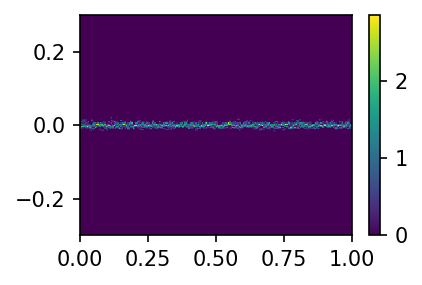

In [4]:
#> Make some electrons

electrons=ParticlesModule.ParticleArrayOrderedInit(
        number_particles=1000,mass=1.0,charge=-1.0,
        x_length=maximum(grid.x),y_length=maximum(grid.y),z_length=maximum(grid.z),
        vx_thermal_speed=thermal_velocity*1.0,vy_thermal_speed=0.0,vz_thermal_speed=0.0,
    particle_shape_x=(grid.x[2]-grid.x[1]),
        time_step=time_step
    );

#ParticlesModule.AddParticleDrift_x!(electrons,0.0)
ParticlesModule.AddParticleRandomPositionPerturbation_x!(electrons,5.0e-2*(grid.x[2]-grid.x[1]))
#ParticlesModule.AddParticleCosineVelocityPerturbation_x!(electrons,5.0e-1*sqrt(temperature),0.0e-1,2*pi/(grid.x[end]-grid.x[1]))
#ParticlesModule.AddParticleCosinePositionPerturbation_x!(electrons,1.0e-1*(grid.x[2]-grid.x[1]),2*pi/(grid.x[end]-grid.x[1]))
#ParticlesModule.AddParticleCosinePositionPerturbation_x!(electrons,5.0e-2*(grid.x[2]-grid.x[1]),2*pi)

ParticleGridInteractionModule.ApplyPeriodicParticleBoundary!(electrons,grid)
electron_density=ParticleGridInteractionModule.ScatterParticleToGrid_x(
    electrons,grid
)
FieldModule.ApplyPeriodicBoundary!(electron_density)
electron_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x(electron_density,electrons,grid);

plt.figure(figsize=(3,2),dpi=150)
phase_space_density=ParticleGridInteractionModule.ScatterParticleToGrid_x_vx(
    electrons,grid,vgrid
)
plt.pcolormesh(
    grid.x,vgrid.x,(phase_space_density)
)
plt.colorbar()
plt.tight_layout()

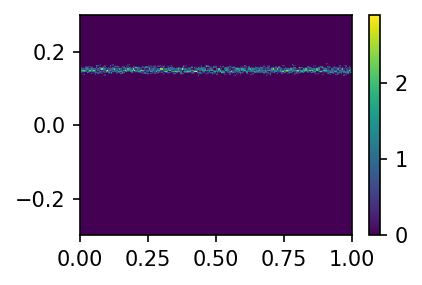

In [5]:
#> Make some beam electrons
beam_electrons=ParticlesModule.ParticleArrayOrderedInit(
        number_particles=1000,mass=1.0,charge=-1.0,
        x_length=maximum(grid.x),y_length=maximum(grid.y),z_length=maximum(grid.z),
        vx_thermal_speed=thermal_velocity*1.0,vy_thermal_speed=0.0,vz_thermal_speed=0.0,
    particle_shape_x=(grid.x[2]-grid.x[1]),
        time_step=time_step
    );

ParticlesModule.AddParticleDrift_x!(beam_electrons,beam_velocity)
ParticlesModule.AddParticleRandomPositionPerturbation_x!(beam_electrons,5.0e-2*(grid.x[2]-grid.x[1]))

ParticleGridInteractionModule.ApplyPeriodicParticleBoundary!(beam_electrons,grid)
beam_electron_density=ParticleGridInteractionModule.ScatterParticleToGrid_x(
    beam_electrons,grid
)
FieldModule.ApplyPeriodicBoundary!(beam_electron_density)
beam_electron_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x(beam_electron_density,beam_electrons,grid);

plt.figure(figsize=(3,2),dpi=150)
phase_space_density=ParticleGridInteractionModule.ScatterParticleToGrid_x_vx(
    beam_electrons,grid,vgrid
)
plt.pcolormesh(
    grid.x,vgrid.x,(phase_space_density)
)
plt.colorbar()
plt.tight_layout()

In [6]:
#> Make some static ions
ions=ParticlesModule.ParticleArrayOrderedInit(
        number_particles=1000,mass=1836.2,charge=1.0,
        x_length=maximum(grid.x),y_length=maximum(grid.y),z_length=maximum(grid.z),
        vx_thermal_speed=sqrt(temperature)*0.0,vy_thermal_speed=0.0,vz_thermal_speed=0.0,
        particle_shape_x=grid.x[end]-grid.x[1],
        time_step=1.0
    );

ParticleGridInteractionModule.ApplyPeriodicParticleBoundary!(ions,grid)
ion_density=ParticleGridInteractionModule.ScatterParticleToGrid_x(
    ions,grid
)
FieldModule.ApplyPeriodicBoundary!(ion_density)
ion_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x(ion_density,ions,grid);

In [7]:
electron_density = ParticleGridInteractionModule.ScatterParticleToGrid_x(electrons,grid);
electron_density *= 1.0
FieldModule.ApplyPeriodicBoundary!(electron_density)
electron_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x(electron_density,electrons,grid);
electron_density_average = sum(electron_density)/float(length(electron_density))
println("initial average electron density : ",electron_density_average)
for ip in 1:electrons.number_particles
    electrons.particle[ip].f_over_g/=(electron_density_average)/bulk_density_ratio
end
electron_density = ParticleGridInteractionModule.ScatterParticleToGrid_x(electrons,grid);
FieldModule.ApplyPeriodicBoundary!(electron_density)
electron_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x(electron_density,electrons,grid);
electron_density_average = sum(electron_density)/float(length(electron_density))
println("initial average electron density : ",electron_density_average)

initial average electron density : 4.999944748302707
initial average electron density : 0.8999999999999999


In [8]:
beam_electron_density = ParticleGridInteractionModule.ScatterParticleToGrid_x(beam_electrons,grid);
beam_electron_density *= 1.0
FieldModule.ApplyPeriodicBoundary!(beam_electron_density)
beam_electron_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x(beam_electron_density,beam_electrons,grid);
beam_electron_density_average = sum(beam_electron_density)/float(length(beam_electron_density))
println("initial average beam_electron density : ",beam_electron_density_average)
for ip in 1:beam_electrons.number_particles
    beam_electrons.particle[ip].f_over_g/=(beam_electron_density_average)/beam_density_ratio
end
beam_electron_density = ParticleGridInteractionModule.ScatterParticleToGrid_x(beam_electrons,grid);
FieldModule.ApplyPeriodicBoundary!(beam_electron_density)
beam_electron_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x(beam_electron_density,beam_electrons,grid);
beam_electron_density_average = sum(beam_electron_density)/float(length(beam_electron_density))
println("initial average beam_electron density : ",beam_electron_density_average)

initial average beam_electron density : 4.9998464736421235
initial average beam_electron density : 0.10000000000000002


In [9]:
ion_density = ParticleGridInteractionModule.ScatterParticleToGrid_x(ions,grid);
ion_density *= 1.0
FieldModule.ApplyPeriodicBoundary!(ion_density)
ion_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x(ion_density,ions,grid);
ion_density_average = sum(ion_density)/float(length(ion_density))
println("initial average ion density : ",ion_density_average)
for ip in 1:ions.number_particles
    ions.particle[ip].f_over_g/=ion_density_average
end
ion_density = ParticleGridInteractionModule.ScatterParticleToGrid_x(ions,grid);
FieldModule.ApplyPeriodicBoundary!(ion_density)
ion_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x(ion_density,ions,grid);
ion_density_average = sum(ion_density)/float(length(ion_density))
println("initial average ion density : ",ion_density_average)

initial average ion density : 5.0
initial average ion density : 1.0000000000000002


In [10]:
phi=FieldModule.SolvePoissonEquation_FFT_1D(
        ion_density.-electron_density-beam_electron_density,
        grid
    );
electric_field_x=FieldModule.CalculateElectricField_FFT_1D(
        phi,grid
    );
electric_field_x = ParticleGridInteractionModule.ApplyFiniteParticleShape_x(electric_field_x,electrons,grid);

density_all=ElasticArray{Float64}(undef, length(phi), 0);
append!(density_all, (ion_density.-electron_density-beam_electron_density));

potential_all=ElasticArray{Float64}(undef, length(phi), 0);
append!(potential_all, phi);

electric_field_all=ElasticArray{Float64}(undef, length(electric_field_x), 0);
append!(electric_field_all, electric_field_x);

time_all=[electrons.particle[1].dt]

ParticlesModule.UpdateParticleKineticEnergy!(electrons)
energy_all=[electrons.total_kinetic_energy]

ParticlesModule.UpdateParticleKineticEnergy!(beam_electrons)
beam_energy_all=[beam_electrons.total_kinetic_energy]




1-element Array{Float64,1}:
 -0.00013311410180013913

In [11]:
using Plots
using LaTeXStrings
using Images
TINY_VALUE=1e-10

1.0e-10

In [12]:
if(true)
    anim = @animate for i in 1:number_time_snaps
    #> Diagnostics
        phase_space_density_bulk=ParticleGridInteractionModule.ScatterParticleToGrid_x_vx(
            electrons,grid,vgrid
        )
        phase_space_density_beam=ParticleGridInteractionModule.ScatterParticleToGrid_x_vx(
            beam_electrons,grid,vgrid
        )
        phase_space_density = phase_space_density_bulk + phase_space_density_beam
        phase_space_density_smoothed = imfilter(
            phase_space_density, 
            Kernel.gaussian((
                    length(grid.x)*0.005,
                    length(vgrid.x)*0.005))
        )
        clevels=range(-6,stop=0,length=15)

        plot(
            plot(
                grid.x,
                (
                    transpose(sum(phase_space_density,dims=1))
                ),
                legend=false,
                #label="sum over v"
            ),
            plot(
                vgrid.x,        
                (
                    sum(phase_space_density,dims=2)
                ).+TINY_VALUE,
                legend=false,
                #label="sum over x"
            ),
            contour(
                grid.x,vgrid.x,        
                log10.(
                    abs.((phase_space_density_smoothed)
                    /maximum(abs.(phase_space_density_smoothed)))
                    .+TINY_VALUE
                ),
                levels=clevels,
                fill=true,
                clims=(minimum(clevels),maximum(clevels))
            ),
            layout=(1,3),
            size=(900,150)
        )
        plot!(sp=1, ylims=(0,3), xlims=(0,1), 
                title="f(x)", frame=:axes)
        plot!(sp=2, yaxis=:log, ylims=(2e-2, 2e2), xlims=(-0.3,0.3), 
                title="f(v)", frame=:axes)
        plot!(sp=3, 
                title="f_Bulk+f_Beam", frame=:zerolines)
        for i_snap in 1:number_time_steps
            #> Scatter particles to grid
            electron_density = ParticleGridInteractionModule.ScatterParticleToGrid_x(electrons,grid);
            FieldModule.ApplyPeriodicBoundary!(electron_density);    
            electron_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x(electron_density,electrons,grid);

            #> Scatter particles to grid
            beam_electron_density = ParticleGridInteractionModule.ScatterParticleToGrid_x(beam_electrons,grid);
            FieldModule.ApplyPeriodicBoundary!(beam_electron_density);    
            beam_electron_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x(beam_electron_density,beam_electrons,grid);

            #> Solve for fields on grid
            phi=FieldModule.SolvePoissonEquation_FFT_1D(
                ion_density.-electron_density-beam_electron_density,
                grid
            );
            electric_field_x=FieldModule.CalculateElectricField_FFT_1D(
                phi,grid
            );
            #>> Field diagnostics
            append!(potential_all, phi);
            append!(electric_field_all, electric_field_x); 
            append!(density_all, (ion_density.-electron_density-beam_electron_density));


            #> Particle diagnostics
            push!(time_all,time_all[end]+electrons.particle[1].dt);            
            ParticlesModule.UpdateParticleKineticEnergy!(electrons)
            push!(energy_all,electrons.total_kinetic_energy)
            ParticlesModule.UpdateParticleKineticEnergy!(beam_electrons)
            push!(beam_energy_all,beam_electrons.total_kinetic_energy)

            #> Scatter field to particles
            ParticleGridInteractionModule.ScatterFieldToParticle_Ex!(
                electric_field_x,electrons,grid
            )        

            #> Scatter field to particles
            ParticleGridInteractionModule.ScatterFieldToParticle_Ex!(
                electric_field_x,beam_electrons,grid
            )        

            #> Push particles
            ParticlesModule.UpdateParticlePosition!(electrons)
            ParticlesModule.UpdateParticleVelocity!(electrons)
            ParticleGridInteractionModule.ApplyPeriodicParticleBoundary!(electrons,grid)

            #> Push particles
            ParticlesModule.UpdateParticlePosition!(beam_electrons)
            ParticlesModule.UpdateParticleVelocity!(beam_electrons)
            ParticleGridInteractionModule.ApplyPeriodicParticleBoundary!(beam_electrons,grid)
        end
    end
end

Animation("/var/folders/_d/y_5xlk_d7295pfkx2kjh9mz99qs8qp/T/jl_dRxIWo", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000191.png", "000192.png", "000193.png", "000194.png", "000195.png", "000196.png", "000197.png", "000198.png", "000199.png", "000200.png"])

In [13]:
gif(anim, "anim_fps15.gif", fps = 15)

┌ Info: Saved animation to 
│   fn = /Users/clau/PBJ/anim_fps15.gif
└ @ Plots /Users/clau/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/Users/clau/PBJ/anim_fps15.gif")

In [14]:
gif(anim, "anim_fps50.gif", fps = 50)

┌ Info: Saved animation to 
│   fn = /Users/clau/PBJ/anim_fps50.gif
└ @ Plots /Users/clau/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/Users/clau/PBJ/anim_fps50.gif")

In [15]:
if(false)
    for i in 1:number_time_steps
        #> Diagnostics
        if(mod(i,number_time_snaps)==0)
            plt.figure(figsize=(10,3),dpi=150)
            plt.subplot(1,3,1)
            plt.title("bulk electrons, t="*string(i*electrons.particle[1].dt))
            phase_space_density_bulk=ParticleGridInteractionModule.ScatterParticleToGrid_x_vx(
                electrons,grid,vgrid
            )
            plt.pcolormesh(
                grid.x,vgrid.x,
                log10.(
                    (phase_space_density_bulk)
                    /maximum(abs.(phase_space_density_bulk))
                    ),
                cmap="hot_r",#shading="gouraud",
                vmax=0.0,vmin=-4.0
            )
            plt.colorbar()
            plt.subplot(1,3,2)
            plt.title("beam electrons, t="*string(i*beam_electrons.particle[1].dt))
            phase_space_density_beam=ParticleGridInteractionModule.ScatterParticleToGrid_x_vx(
                beam_electrons,grid,vgrid
            )
            plt.pcolormesh(
                grid.x,vgrid.x,
                log10.(
                    (phase_space_density_beam)
                    /maximum(abs.(phase_space_density_beam))
                    ),
                cmap="hot_r",#shading="gouraud",
                vmax=0.0,vmin=-4.0
            )
            plt.colorbar()
            plt.subplot(1,3,3)
            plt.title("electrons (log), t="*string(i*beam_electrons.particle[1].dt))
            plt.pcolormesh(
                grid.x,vgrid.x,
                log10.(
                    (phase_space_density_beam+phase_space_density_bulk)
                    /maximum(abs.(phase_space_density_beam+phase_space_density_bulk))
                    ),
                cmap="hot_r",#shading="gouraud",
                vmax=0.0,vmin=-4.0
            )
            plt.colorbar()
            plt.tight_layout()
        end
        #> Scatter particles to grid
        electron_density = ParticleGridInteractionModule.ScatterParticleToGrid_x(electrons,grid);
        FieldModule.ApplyPeriodicBoundary!(electron_density);    
        electron_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x(electron_density,electrons,grid);
        
        #> Scatter particles to grid
        beam_electron_density = ParticleGridInteractionModule.ScatterParticleToGrid_x(beam_electrons,grid);
        FieldModule.ApplyPeriodicBoundary!(beam_electron_density);    
        beam_electron_density = ParticleGridInteractionModule.ApplyFiniteParticleShape_x(beam_electron_density,beam_electrons,grid);
            
        #> Solve for fields on grid
        phi=FieldModule.SolvePoissonEquation_FFT_1D(
            ion_density.-electron_density-beam_electron_density,
            grid
        );
        electric_field_x=FieldModule.CalculateElectricField_FFT_1D(
            phi,grid
        );
        #>> Field diagnostics
        append!(potential_all, phi);
        append!(electric_field_all, electric_field_x); 
        append!(density_all, (ion_density.-electron_density-beam_electron_density));
   
        
        #> Particle diagnostics
        push!(time_all,time_all[end]+electrons.particle[1].dt);            
        ParticlesModule.UpdateParticleKineticEnergy!(electrons)
        push!(energy_all,electrons.total_kinetic_energy)
        ParticlesModule.UpdateParticleKineticEnergy!(beam_electrons)
        push!(beam_energy_all,beam_electrons.total_kinetic_energy)
        
        #> Scatter field to particles
        ParticleGridInteractionModule.ScatterFieldToParticle_Ex!(
            electric_field_x,electrons,grid
        )        
        
        #> Scatter field to particles
        ParticleGridInteractionModule.ScatterFieldToParticle_Ex!(
            electric_field_x,beam_electrons,grid
        )        
            
        #> Push particles
        ParticlesModule.UpdateParticlePosition!(electrons)
        ParticlesModule.UpdateParticleVelocity!(electrons)
        ParticleGridInteractionModule.ApplyPeriodicParticleBoundary!(electrons,grid)
        
        #> Push particles
        ParticlesModule.UpdateParticlePosition!(beam_electrons)
        ParticlesModule.UpdateParticleVelocity!(beam_electrons)
        ParticleGridInteractionModule.ApplyPeriodicParticleBoundary!(beam_electrons,grid)
    end
end

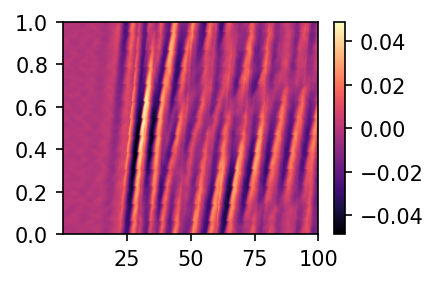

In [16]:
plt.figure(figsize=(3,2),dpi=150)
plt.pcolormesh(
    time_all,
    grid.x,
    electric_field_all,shading="gouraud",cmap="magma"
)
plt.colorbar()
plt.tight_layout()

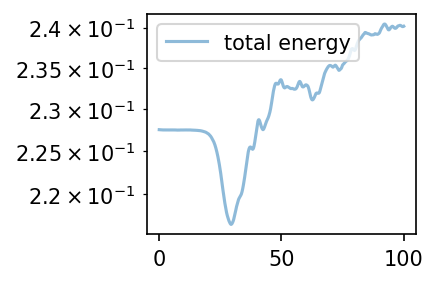

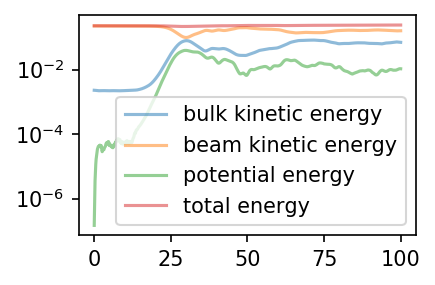

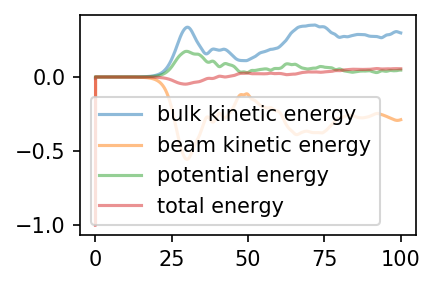

In [27]:
potential_energy_all = zero(time_all)
for i=1:length(potential_energy_all)
    #> Note that the last index is a duplicate so.. ignore
    #potential_energy_all[i] = sum((electric_field_all[1:end-1,i].^2)*(grid.x[2]-grid.x[1]))
    potential_energy_all[i] = 150*0.5*sum((potential_all[1:end-1,i].*density_all[1:end-1,i])*(grid.x[2]-grid.x[1]))
end
total_energy = energy_all+potential_energy_all+beam_energy_all
plt.figure(figsize=(3,2),dpi=150)
i_start = 5
plt.plot(
    time_all[i_start:end],
    total_energy[i_start:end],
    alpha=0.5,
    label="total energy"
)
plt.yscale("log")
plt.legend()
plt.tight_layout()

plt.figure(figsize=(3,2),dpi=150)
i_start = 5
plt.plot(
    time_all[i_start:end],
    energy_all[i_start:end],
    alpha=0.5,
    label="bulk kinetic energy"
)
plt.plot(
    time_all[i_start:end],
    beam_energy_all[i_start:end],
    alpha=0.5,
    label="beam kinetic energy"
)
plt.plot(
    time_all[i_start:end],
    potential_energy_all[i_start:end],
    alpha=0.5,
    label="potential energy"
)
plt.plot(
    time_all[i_start:end],
    total_energy[i_start:end],
    alpha=0.5,
    label="total energy"
)
plt.yscale("log")
plt.legend()
plt.tight_layout()

plt.figure(figsize=(3,2),dpi=150)
i_start = 5
plt.plot(
    time_all,
    (energy_all.-energy_all[i_start])/total_energy[i_start],
    alpha=0.5,
    label="bulk kinetic energy"
)
plt.plot(
    time_all,
    (beam_energy_all.-beam_energy_all[i_start])/total_energy[i_start],
    alpha=0.5,
    label="beam kinetic energy"
)
plt.plot(
    time_all,
    (potential_energy_all.-potential_energy_all[i_start])/total_energy[i_start],
    alpha=0.5,
    label="potential energy"
)
plt.plot(
    time_all,
    (total_energy.-total_energy[i_start])/total_energy[i_start],
    alpha=0.5,
    label="total energy"
)
#plt.yscale("log")
plt.legend()
plt.tight_layout()

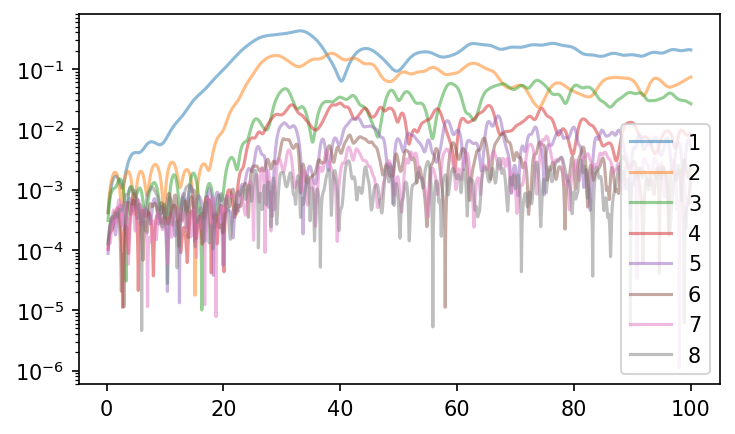

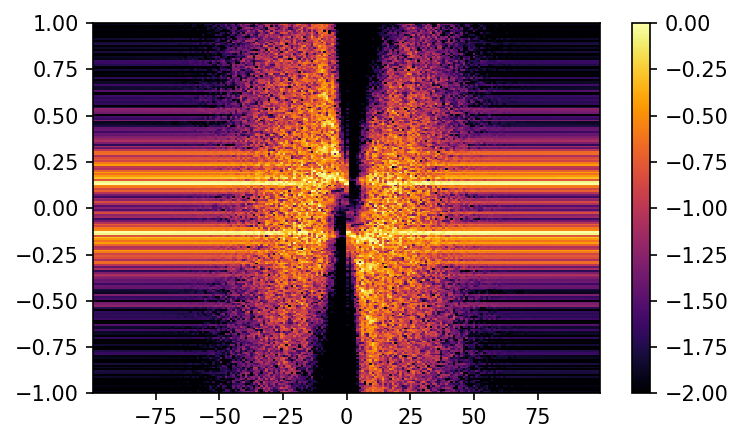

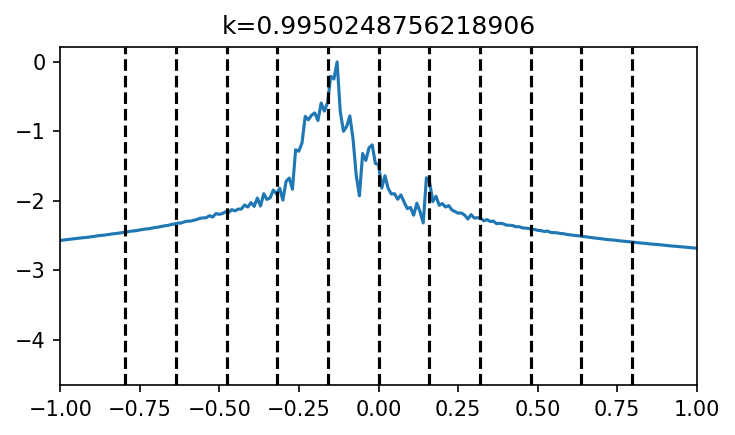

┌ Warning: `fftfreq(n::Int, fs::Real=1)` is deprecated, use `FFTW.fftfreq(n, fs)` instead.
│   caller = top-level scope at In[18]:6
└ @ Core In[18]:6
┌ Warning: `fftfreq(n::Int, fs::Real=1)` is deprecated, use `FFTW.fftfreq(n, fs)` instead.
│   caller = top-level scope at In[18]:8
└ @ Core In[18]:8


In [18]:
import FFTW
import DSP

start_time = 50
plt.figure(figsize=(5,3),dpi=150)

k_FFT=DSP.fftfreq(size(potential_all[:,start_time:end])[1],1.0/(grid.x[2]-grid.x[1])) |> FFTW.fftshift
omega_FFT=DSP.fftfreq(size(potential_all[:,start_time:end])[2],1.0/(time_all[2]-time_all[1])) |> FFTW.fftshift

phi_fft = FFTW.rfft(potential_all,1)
for i in 2:9
    plt.plot(
        time_all[start_time:end],
        abs.(phi_fft[i,start_time:end]),
        #real(phi_fft[i,start_time:end]),
        marker="",ls="-",alpha=0.5,
        label=string(i-1)
    )
end
plt.legend()
plt.yscale("log")
plt.tight_layout()

plt.figure(figsize=(5,3),dpi=150)
phi_fft2 = transpose(FFTW.fftshift(FFTW.fft(potential_all[:,start_time:end])))
for i in 1:size(phi_fft2)[2]
    phi_fft2[:,i]/=maximum(abs.(phi_fft2[:,i]))
end
if(true)
    plt.pcolormesh(
        k_FFT,
        omega_FFT,
#        (abs.(phi_fft2))
        log10.(abs.(phi_fft2)),
        cmap="inferno",
        vmin=-2,vmax=0
    )
    plt.tight_layout()
    plt.ylim(-1,1);
    #plt.xlim(-0.5,0.5)
    #plt.ylim(-5,5)
    plt.colorbar()
end

plt.figure(figsize=(5,3),dpi=150)
j_mid = round(Int,size(phi_fft2)[2]/2)+2
i_mid = round(Int,size(phi_fft2)[1]/2)+1
plt.plot(
    omega_FFT,
    log10.(abs.(phi_fft2[:,j_mid]))
)
for i in -5:5
    plt.axvline(i/(2pi),c="k",ls="--")
end
plt.title("k="*string(k_FFT[j_mid]))
plt.xlim(-1,1)
plt.tight_layout()



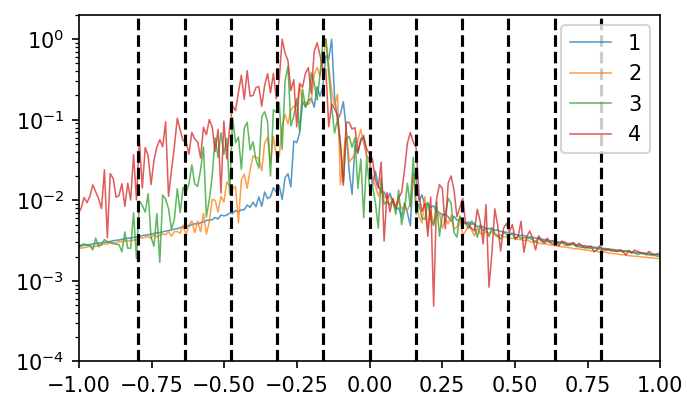

┌ Warning: `fftfreq(n::Int, fs::Real=1)` is deprecated, use `FFTW.fftfreq(n, fs)` instead.
│   caller = top-level scope at In[19]:6
└ @ Core In[19]:6
┌ Warning: `fftfreq(n::Int, fs::Real=1)` is deprecated, use `FFTW.fftfreq(n, fs)` instead.
│   caller = top-level scope at In[19]:8
└ @ Core In[19]:8


In [19]:
import FFTW
import DSP

start_time = 50
plt.figure(figsize=(5,3),dpi=150)

k_FFT=DSP.fftfreq(size(potential_all[:,start_time:end])[1],1.0/(grid.x[2]-grid.x[1])) |> FFTW.fftshift
omega_FFT=DSP.fftfreq(size(potential_all[:,start_time:end])[2],1.0/(time_all[2]-time_all[1])) |> FFTW.fftshift

phi_fft = FFTW.rfft(potential_all,1)
for i in 2:5
    phi_fft_2 = FFTW.fftshift(FFTW.fft(phi_fft[i,start_time:end]))
    plt.plot(
        omega_FFT,
        abs.(phi_fft_2)/maximum(abs.(phi_fft_2)),
        marker="",ls="-",lw=0.75,alpha=0.75,
        label=string(i-1)
    )
end
plt.xlim(-1,1)
plt.ylim(1e-4,0.2e1)
plt.yscale("log")
plt.legend()
for i in -5:5
    plt.axvline(i/(2*pi),c="k",ls="--")
end

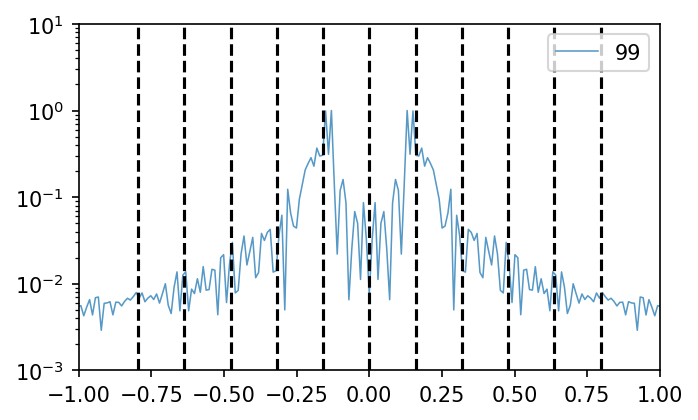

┌ Warning: `fftfreq(n::Int, fs::Real=1)` is deprecated, use `FFTW.fftfreq(n, fs)` instead.
│   caller = top-level scope at In[20]:6
└ @ Core In[20]:6
┌ Warning: `fftfreq(n::Int, fs::Real=1)` is deprecated, use `FFTW.fftfreq(n, fs)` instead.
│   caller = top-level scope at In[20]:8
└ @ Core In[20]:8


In [20]:
import FFTW
import DSP

start_time = 50
plt.figure(figsize=(5,3),dpi=150)

k_FFT=DSP.fftfreq(size(potential_all[:,start_time:end])[1],1.0/(grid.x[2]-grid.x[1])) |> FFTW.fftshift
omega_FFT=DSP.fftfreq(size(potential_all[:,start_time:end])[2],1.0/(time_all[2]-time_all[1])) |> FFTW.fftshift

phi_fft = FFTW.rfft(potential_all,1)
i=round(Int,length(grid.x)/2)
phi_fft_2 = FFTW.fftshift(FFTW.fft(potential_all[i,start_time:end]))
plt.plot(
    omega_FFT,
    abs.(phi_fft_2)/maximum(abs.(phi_fft_2)),
    marker="",ls="-",lw=0.75,alpha=0.75,
    label=string(i-1)
)
plt.xlim(-1,1)
plt.ylim(1e-3,1e1)
plt.yscale("log")
plt.legend()
for i in -5:5
    plt.axvline(i/(2pi),c="k",ls="--")
end